<a href="https://colab.research.google.com/github/Seminahn01/DS4002-Project1/blob/main/Sentimentanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [2]:
# Download necessary NLP data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()

In [5]:
# Load dataset
df = pd.read_csv("/content/movie_data_final.csv")

# Display dataset information
print(df.head())

   Unnamed: 0           title  review_id  \
0           1  101 Dalmatians      12794   
1           2  101 Dalmatians      12792   
2           3  101 Dalmatians      12791   
3           4  101 Dalmatians      12795   
4           5  101 Dalmatians      12793   

                                         review_text  lifetime_gross  \
0  Cast: Glenn Close, Jeff Daniels, Joely Richard...       320689294   
1  Part vamp, part tramp, and all camp, Glenn Clo...       320689294   
2  Cast: Glenn Close, Jeff Daniels, Joely Richard...       320689294   
3  Tragic, perhaps, the fate that befalls the Dis...       320689294   
4  Well, another new Disney movie is coming out a...       320689294   

   release_year  
0          1996  
1          1996  
2          1996  
3          1996  
4          1996  


In [14]:
# Perform sentiment analysis
df["sentiment_score"] = df["review_text"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

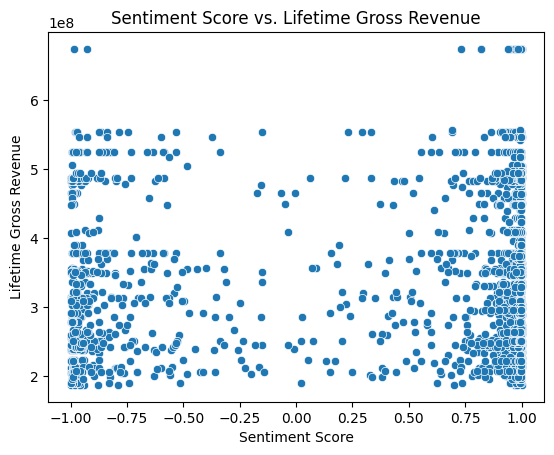

In [13]:
# Exploratory Data Analysis (EDA)
sns.scatterplot(data=df, x="sentiment_score", y="lifetime_gross")
plt.title("Sentiment Score vs. Lifetime Gross Revenue")
plt.xlabel("Sentiment Score")
plt.ylabel("Lifetime Gross Revenue")
plt.show()

In [17]:
# Reduce the number of TF-IDF features further to improve efficiency
tfidf = TfidfVectorizer(max_features=100)

In [18]:
# Transform the review text into numerical features
X_text = tfidf.fit_transform(df["review_text"].astype(str))

In [19]:
# Combine TF-IDF features with review length
X_combined = hstack((X_text, df[["review_length"]]))

In [20]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_combined, df["lifetime_gross"], test_size=0.2, random_state=42)

# Train Optimized XGBoost Model (only XGBoost to avoid memory issues)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=50, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [37]:
# Create a DataFrame with actual vs. predicted revenue for comparison
predictions_df = pd.DataFrame({
    "Actual Revenue": y_test.values,
    "Predicted Revenue": y_pred_xgb
})

# Display the results
print(predictions_df.head(30))

    Actual Revenue  Predicted Revenue
0        368780809        323888320.0
1        350448145        261466320.0
2        244721064        292042016.0
3        245077583        426024064.0
4        333011068        282540032.0
5        379014294        522257728.0
6        196567262        388016576.0
7        245700832        247841376.0
8        363994265        343295264.0
9        497375381        266375952.0
10       256271286        313549888.0
11       235483004        303746912.0
12       206071526        313579456.0
13       244721064        281415776.0
14       262821940        339007232.0
15       487576624        353052832.0
16       482352390        358216992.0
17       206071526        325233792.0
18       245852179        398199904.0
19       222104681        288931264.0
20       487576624        440297536.0
21       213928762        322890432.0
22       225933435        336646784.0
23       198467607        269369440.0
24       212404396        317817056.0
25       457

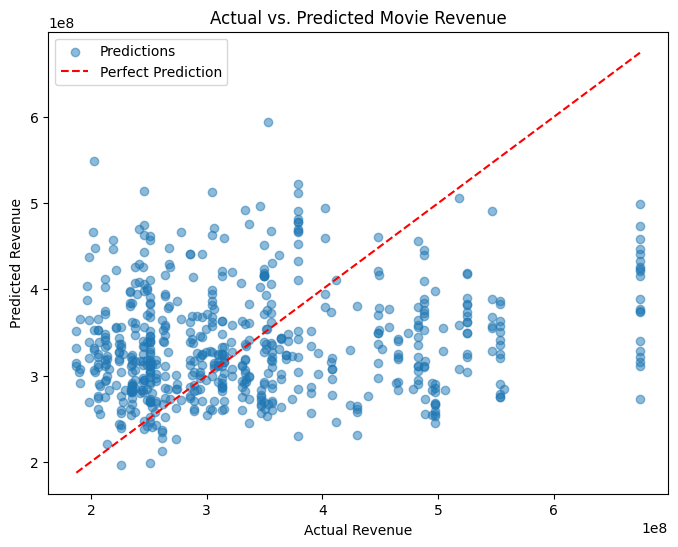

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs. Predicted Movie Revenue")
plt.legend()
plt.show()